In [1]:
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchmetrics import Accuracy
from torchvision import models

import torch.optim as optim
from cleverhans.torch.attacks.projected_gradient_descent import (projected_gradient_descent)

import quantus
import captum
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import copy
import gc

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dataset = datasets.MNIST(root="./datasets/", train=True, download=True)
test_dataset = datasets.MNIST(root="./datasets/", train=False, download = False)

In [3]:
class_names = train_dataset.classes

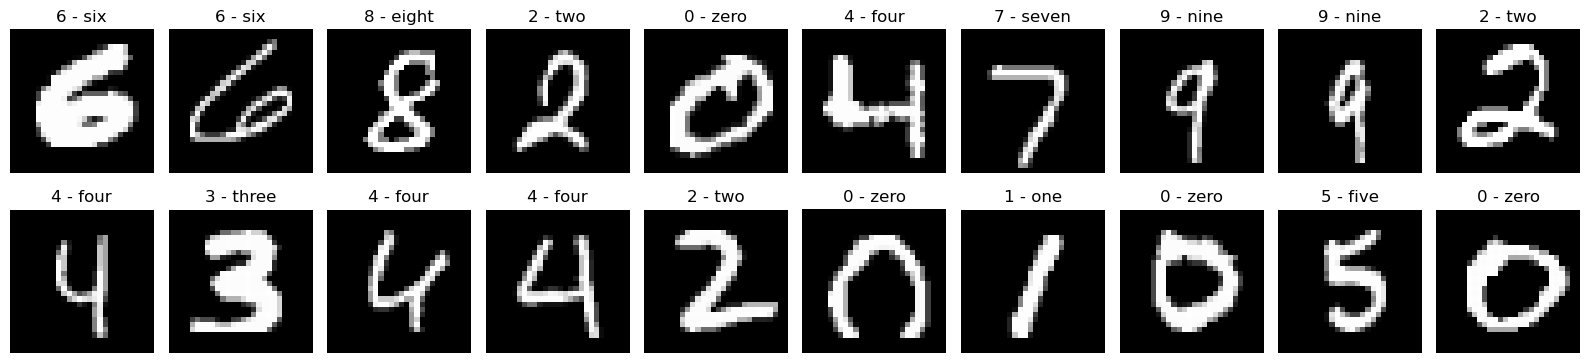

In [4]:
import torch
torch.manual_seed(42)     # Search on the internet why '42' is special or
                          # even '42 * 2' = 84

fig = plt.figure(figsize=(16, 4))
rows, cols = 2, 10

for i in range(1, (rows*cols) + 1):
    rand_ind = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[rand_ind]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.title(f"{class_names[label]}")
    plt.axis(False)
    plt.tight_layout()

In [5]:
mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

In [6]:
train_dataset = datasets.MNIST(root="./datasets", train=True, download = False, transform = mnist_transforms)
test_dataset = datasets.MNIST(root="./datasets", train=False, download = False, transform = mnist_transforms)

In [7]:
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset = train_dataset, lengths=[train_size, val_size])

In [8]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 32, shuffle=True)
val_loader = DataLoader(dataset = val_dataset, batch_size = 32, shuffle=True)

In [9]:
# class LeNet5V1(nn.Module):
#     def __init__(self):
#         super(LeNet5V1, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 3, 1)
#         self.conv2 = nn.Conv2d(32, 64, 3, 1)
#         self.dropout1 = nn.Dropout(0.25)
#         self.dropout2 = nn.Dropout(0.5)
#         self.fc1 = nn.Linear(9216, 128)
#         self.fc2 = nn.Linear(128, 10)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.dropout2(x)
#         x = self.fc2(x)
#         output = F.log_softmax(x, dim=1)
#         return output

class LeNet5V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            
            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5
            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.feature(x))


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5V1().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-4)
EPOCHS = 10
accuracy = Accuracy(task='multiclass', num_classes=10).to(device)
eps= [0.01, 0.03, 0.06, 0.1, 0.3, 0.5]

In [22]:
from tqdm.notebook import tqdm

accuracy = accuracy.to(device)

for epoch in tqdm(range(EPOCHS)):
    # Training loop
    train_acc = 0.0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        X = projected_gradient_descent(model, X, eps[0], eps[0]/10, 40, np.inf )
        model.train()
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        
        acc = accuracy(y_pred, y)
        train_acc += acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_acc /= len(train_loader)
        
    # Validation loop
    val_loss, val_acc = 0.0, 0.0
    model.eval()
    with torch.inference_mode():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X)
            
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
            
            acc = accuracy(y_pred, y)
            val_acc += acc
            
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
    
    print(f"Epoch: {epoch}| Train acc: {(100* train_acc):.5f}| Val loss: {val_loss: .5f}| Val acc: {(100*val_acc): .5f}")
                 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0| Train acc: 83.62893| Val loss:  0.28330| Val acc:  91.97141
Epoch: 1| Train acc: 93.09280| Val loss:  0.16995| Val acc:  94.96342
Epoch: 2| Train acc: 95.26622| Val loss:  0.11989| Val acc:  96.54255
Epoch: 3| Train acc: 96.51400| Val loss:  0.08968| Val acc:  97.32380
Epoch: 4| Train acc: 97.30820| Val loss:  0.07244| Val acc:  97.92220
Epoch: 5| Train acc: 97.72660| Val loss:  0.06652| Val acc:  97.95544
Epoch: 6| Train acc: 98.03577| Val loss:  0.05671| Val acc:  98.17154
Epoch: 7| Train acc: 98.30976| Val loss:  0.05061| Val acc:  98.35439
Epoch: 8| Train acc: 98.43380| Val loss:  0.04684| Val acc:  98.60372
Epoch: 9| Train acc: 98.59116| Val loss:  0.04255| Val acc:  98.68683


In [24]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet5_v1_mnist_adv.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Saving the model
print(f"Saving the model: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)



Saving the model: models\lenet5_v1_mnist_adv.pth


In [23]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet5_v1_mnist_adv.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
# Loading the saved model
model_lenet5_v1_mnist_adv_loaded = LeNet5V1()
model_lenet5_v1_mnist_adv_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [25]:
test_loss, test_acc = 0, 0

model = model_lenet5_v1_mnist_adv_loaded.to(device)

model.eval()
with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        
        test_loss += loss_fn(y_pred, y)
        test_acc += accuracy(y_pred, y)
        
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

print(f"Test loss: {test_loss: .5f}| Test acc: {(100* test_acc): .5f}")

Test loss:  0.04371| Test acc:  98.52236


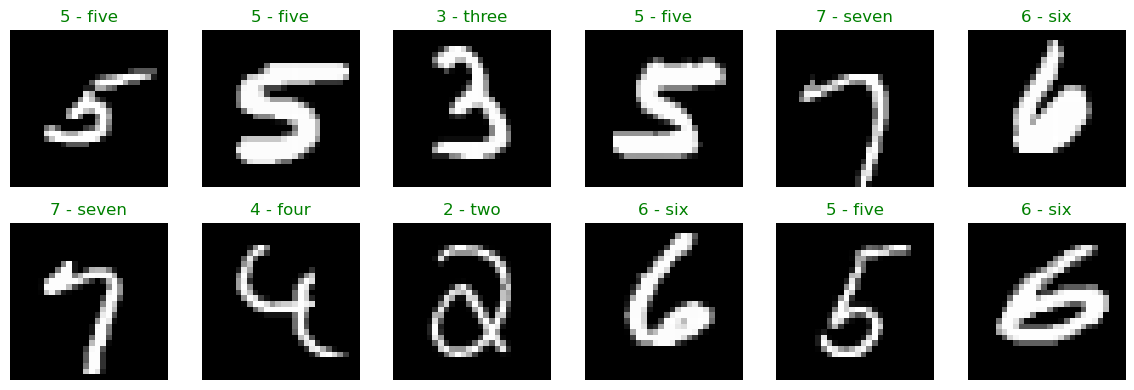

In [27]:
# See random images with their labels
torch.manual_seed(42)  # setting random seed
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12, 4))

rows, cols = 2, 6
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(test_dataset), size=[1]).item()
    img, label_gt = test_dataset[random_idx]
    img_temp = img.unsqueeze(dim=0).to(device)
    # print(img.shape)
    label_pred = torch.argmax(model_lenet5_v1_mnist_adv_loaded(img_temp))
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)    # CWH --> WHC
    plt.imshow(img, cmap='gray')
    if label_pred == label_gt:
        plt.title(class_names[label_pred], color='g') # for correct prediction
    else:
        plt.title(class_names[label_pred], color='r') # for incorrect prediction
    plt.axis(False)
    plt.tight_layout();

In [29]:
def explainer_wrapper(**kwargs):
    if kwargs["method"] == "Saliency":
        return saliency_explainer(**kwargs)
    elif kwargs["method"] == "IntegratedGradients":
        return integrated_explainer(**kwargs)
    elif kwargs["method"] == "SmoothGrad":
        return smoothgrad_explainer(**kwargs)
    elif kwargs["method"] == "NoiseGrad":
        return noisegrad_explainer(**kwargs)
    else:
        return ValueError("Explanation function doesnt exist")


def saliency_explainer(model, inputs, targets, abs=True, normalise = True, *args, **kwargs):
    gc.collect()
    torch.cuda.empty_cache()

    # Set model in evaluate mode.
    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs).reshape(-1, kwargs.get("nr_channels", 1), kwargs.get("img_size", 28),kwargs.get("img_size", 28)).to(kwargs.get("device", None))
        )

    if not isinstance(targets, torch.Tensor):
        targets = (
            torch.as_tensor(targets).long().to(kwargs.get("device", None))
        )

    assert(
        len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size)"

    explanation = (
        Saliency(model)
        .attribute(inputs, targets, abs=abs)
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 28), kwargs.get("img_size", 28))
        .cpu()
        .data
    )

    gc.collect()
    torch.cuda.empty_cache()

    explanation = explanation.numpy()
    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation


def integrated_explainer(
    model, inputs, targets, abs=True, normalise=True, *args, **kwargs
) -> np.array:

    gc.collect()
    torch.cuda.empty_cache()

    # Set model in evaluate mode.
    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs).reshape(-1,kwargs.get("nr_channels", 1),kwargs.get("img_size", 28),kwargs.get("img_size", 28),).to(kwargs.get("device", None))
        )
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (
        len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size)."
    
    explanation = (
        IntegratedGradients(model)
        .attribute(
            inputs=inputs,
            target=targets,
            baselines=torch.zeros_like(inputs),
            n_steps=10,
            method="riemann_trapezoid",
        )
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 28), kwargs.get("img_size", 28))
        .cpu()
        .data
    )

    gc.collect()
    torch.cuda.empty_cache()

    explanation = explanation.numpy()
    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation


def smoothgrad_explainer(model, inputs, targets, abs=True, normalise=True, stdevs=0.15, nt_samples=10, *args, **kwargs):
    std = kwargs.get("std", 0.15)  # Standard deviation for input noise
    n = kwargs.get("n", 10)  # Number of noisy samples
    clip = kwargs.get("clip", False)

    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs).reshape(-1,kwargs.get("nr_channels", 1),kwargs.get("img_size", 28),kwargs.get("img_size", 28),).to(kwargs.get("device", None))
        )
    
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (len(np.shape(inputs)) == 4), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size"

    if inputs.shape[0] > 1:
        explanation = torch.zeros(
            (
                n,
                inputs.shape[0],
                kwargs.get("img_size", 28),
                kwargs.get("img_size", 28),
            )
        )
    else:
        explanation = torch.zeros(
            (n, kwargs.get("img_size", 28), kwargs.get("img_size", 28))
        )
    saliency = Saliency(model)
    
    # for i in range(n):
    #     # Create noisy input by adding Gaussian noise
    #     # inputs_noisy = inputs + torch.randn_like(inputs) * std
    #     # Clip the noisy inputs to the valid range if needed
    #     if clip:
    #         inputs_noisy = torch.clip(inputs_noisy, min=0.0, max=1.0)

    #     # Compute the saliency map for the noisy input
    explanation = (
        NoiseTunnel(saliency)
        .attribute(inputs=inputs, target=targets, nt_type="smoothgrad", stdevs = stdevs, nt_samples= 10)
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 28), kwargs.get("img_size", 28))
        .cpu()
        .data
    )

    # explanation = explanation.mean(axis=0)
    gc.collect()
    torch.cuda.empty_cache()

    explanation = explanation.numpy()
    # Normalization (if required)
    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    # Convert the result to NumPy if it is still a PyTorch tensor
    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation

def noisegrad_explainer(model, inputs, targets, abs=True, normalise=True, *args, **kwargs):
    std = kwargs.get("std", 0.5)  # Standard deviation for noise
    mean = kwargs.get("mean", 1.0)  # Mean for noise
    n = kwargs.get("n", 10)  # Number of noisy model samples
    # sg_std = kwargs.get("sg_std", 0.1)  # Standard deviation for input noise
    noise_type = kwargs.get("noise_type", "multiplicative")  # Type of noise to apply
    clip = kwargs.get("clip", False)  # Whether to clip inputs to [0, 1]

    def _apply_noise_to_model(model, std, mean, noise_type="multiplicative"):
        """Applies noise to the model parameters."""
        # Create the Gaussian distribution for noise.
        distribution = torch.distributions.normal.Normal(mean, std)
        if std == 0.0:
            with torch.no_grad():
                for param in model.parameters():
                    if noise_type == "additive":
                        param.add_(distribution.sample(param.size()).to(param.device))
                    elif noise_type == "multiplicative":
                        param.mul_(distribution.sample(param.size()).to(param.device))
                    else:
                        raise ValueError("Invalid noise_type. Choose 'additive' or 'multiplicative'.")
        return model

    # Set model to evaluation mode and move it to the appropriate device.
    model.to(kwargs.get("device", None))
    model.eval()

    # Prepare the input data.
    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs).reshape(-1,kwargs.get("nr_channels", 1),kwargs.get("img_size", 28),kwargs.get("img_size", 28),).to(kwargs.get("device", None))
        )

    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert len(inputs.shape) == 4, "Inputs should be of shape (nr_samples, nr_channels, img_size, img_size)."

    if inputs.shape[0] > 1:
        explanation = torch.zeros(
            (
                n,
                inputs.shape[0],
                kwargs.get("img_size", 28),
                kwargs.get("img_size", 28),
            )
        )
    else:
        explanation = torch.zeros(
            (n, kwargs.get("img_size", 28), kwargs.get("img_size", 28))
        )


    for i in range(n):
        # Apply noise to the model.
        noisy_model = _apply_noise_to_model(model, std=std, mean=mean, noise_type=noise_type)

        # Add noise to the input.
        # inputs_noisy = inputs + torch.randn_like(inputs) * sg_std

        # Optionally clip the inputs to the valid range.
        # if clip:
        #     inputs_noisy = torch.clip(inputs_noisy, min=0.0, max=1.0)

        # Compute the saliency map for the noisy model and inputs.
        explanation[i] = (
            Saliency(noisy_model)
            .attribute(inputs, targets, abs=abs)
            .sum(axis=1)
            .reshape(-1, kwargs.get("img_size", 28), kwargs.get("img_size", 28))
            .cpu()
            .data
        )

    # Average the explanations across the noisy samples.
    explanation = explanation.mean(axis=0)

    # Memory management to free unused memory.
    gc.collect()
    torch.cuda.empty_cache()

    explanation = explanation.numpy()
    # Normalize the explanation if needed.
    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    # Convert to NumPy array if it is still a PyTorch tensor.
    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation



In [31]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = next(iter(test_loader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [33]:
import gc
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = saliency_explainer(model=model_lenet5_v1_mnist_adv_loaded.cpu(),
                                    inputs=x_batch,
                                    targets=y_batch,
                                    **{"device": device},
                                    )
# Integrated Gradients.
gc.collect()
torch.cuda.empty_cache()
a_batch_integrad = integrated_explainer(model=model_lenet5_v1_mnist_adv_loaded.cpu(),
                                    inputs=x_batch,
                                    targets=y_batch,
                                    **{"device": device},
                                    )

# SmoothGrad
gc.collect()
torch.cuda.empty_cache()
a_batch_smoothgrad = smoothgrad_explainer(model=model_lenet5_v1_mnist_adv_loaded.to(device), 
                                        inputs=x_batch, 
                                        targets=y_batch,
                                        **{ "device": device})

gc.collect()
torch.cuda.empty_cache()

# # Posterior mean setup for NoiseGrad (same as FusionGrad)
# # posterior_mean = copy.deepcopy(torchvision.model_lenet5_v1_mnist_loaded.to(device).state_dict())

# NoiseGrad explanation for a batch of inputs
a_batch_noisegrad = noisegrad_explainer(
    model=model_lenet5_v1_mnist_adv_loaded.to(device),
    inputs=x_batch,
    targets=y_batch,
    **{
        # "posterior_mean": posterior_mean,  # The base model's mean parameters
        "mean": 1.0,  # Mean for the Gaussian noise applied to model parameters
        "std": 0.5,  # Standard deviation for the Gaussian noise applied to model parameters
        # "sg_std": 0.5,  # Standard deviation for the noise added to the inputs
        "n": 20,  # Number of noisy models to sample
        "noise_type": "multiplicative",  # Type of noise to apply to the model parameters
        "clip": False,  # Optionally clip noisy inputs between [0, 1]
        "device": device  # Device for computation (GPU/CPU)
    }
)


In [34]:
explanations = {
    "Saliency": a_batch_saliency,
    "IntegratedGradients": a_batch_integrad,
    "SmoothGrad": a_batch_smoothgrad,
    "NoiseGrad": a_batch_noisegrad,
    # "NoiseTunnel": a_batch_smooth,
}

In [37]:
xai_methods = list(explanations.keys())
metrics = {
    "Faithfulness":  quantus.ROAD(
        noise=0.01,
        perturb_func=quantus.perturb_func.noisy_linear_imputation,
        percentages=list(range(1, 100, 5)),
        display_progressbar=False,
    ),
    "Input Stability": quantus.RelativeInputStability(
        nr_samples =5,
        return_aggregate=False,
         disable_warnings=True,
    ),
     "Output Stability": quantus.RelativeOutputStability(
        nr_samples = 5,
         return_aggregate=False,
        disable_warnings=True,
    ),
    "Sparseness":  quantus.Sparseness(disable_warnings=True, return_aggregate=True),
    
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


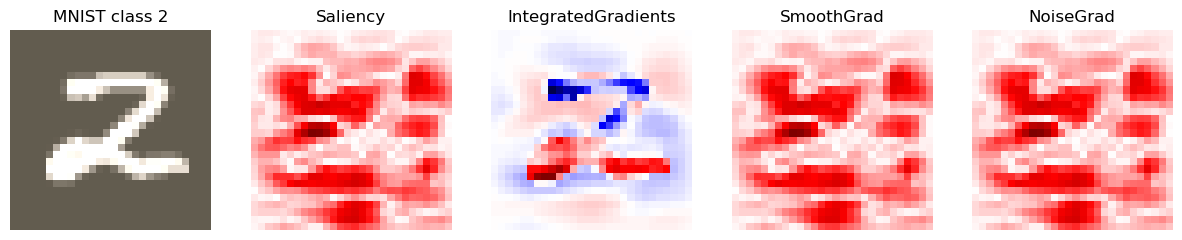

In [55]:
index = 1#random.randint(0, len(x_batch)-1)
fig, axes = plt.subplots(nrows=1, ncols=1+len(explanations), figsize=(15, 8))
axes[0].imshow(np.moveaxis(quantus.normalise_func.denormalise(x_batch[index].cpu().numpy(), mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"MNIST class {y_batch[index].item()}")
axes[0].axis("off"); 
for i, (k, v) in enumerate(explanations.items()):
    axes[i+1].imshow(quantus.normalise_func.normalise_by_negative(explanations[k][index].reshape(28, 28)), cmap="seismic", vmin=-1.0, vmax=1.0)
    axes[i+1].title.set_text(f"{k}")
    axes[i+1].axis("off");

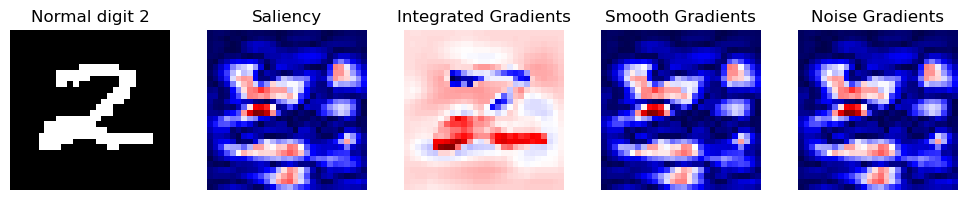

In [61]:
# Plot explanations of normal images!
index = 1
nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(nr_images*5., int(nr_images)))

#plot normal
axes[0].imshow((np.reshape(x_batch[index].cpu().numpy(), (28,28))).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
axes[0].title.set_text(f"Normal digit {y_batch[1].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency[index], cmap="seismic")
axes[1].title.set_text(f"Saliency")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad[index], cmap="seismic")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad[index], cmap="seismic")
axes[3].title.set_text(f"Smooth Gradients")
axes[3].axis("off")
axes[4].imshow(a_batch_noisegrad[index], cmap="seismic")
axes[4].title.set_text(f"Noise Gradients")
axes[4].axis("off")
plt.tight_layout()


plt.show()

In [50]:
# Or, run quantification analysis!
import copy
results = {method : {} for method in xai_methods}

for method in xai_methods:
    for metric, metric_func in metrics.items():

        print(f"Evaluating {metric} of {method} method.")
        gc.collect()
        torch.cuda.empty_cache()
        model=model_lenet5_v1_mnist_adv_loaded.to(device)
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        # Get scores and append results.
        scores = metric_func(
            model = model,
            x_batch=x_batch.cpu().numpy(),
            y_batch=y_batch.cpu().numpy(),
            a_batch=None,
            s_batch=None,
            device=device,
            explain_func=explainer_wrapper,
            explain_func_kwargs={
                "method": method,
                "posterior_mean": copy.deepcopy(
                    model_lenet5_v1_mnist_adv_loaded
                    .to(device)
                    .state_dict()
                ),
                "mean": 1.0,
                "std": 0.5,
                "sg_mean": 0.0,
                "sg_std": 0.5,
                "n": 25,
                "m": 25,
                "noise_type": "multiplicative",
                "device": device,
            },
        )
        results[method][metric] = scores

        # Empty cache.
        gc.collect()
        torch.cuda.empty_cache()
print(results)

Evaluating Faithfulness of Saliency method.
Evaluating Input Stability of Saliency method.
Evaluating Output Stability of Saliency method.
Evaluating Sparseness of Saliency method.
Evaluating Faithfulness of IntegratedGradients method.
Evaluating Input Stability of IntegratedGradients method.
Evaluating Output Stability of IntegratedGradients method.
Evaluating Sparseness of IntegratedGradients method.
Evaluating Faithfulness of SmoothGrad method.
Evaluating Input Stability of SmoothGrad method.
Evaluating Output Stability of SmoothGrad method.
Evaluating Sparseness of SmoothGrad method.
Evaluating Faithfulness of NoiseGrad method.
Evaluating Input Stability of NoiseGrad method.
Evaluating Output Stability of NoiseGrad method.
Evaluating Sparseness of NoiseGrad method.
{'Saliency': {'Faithfulness': {1: 1.0, 6: 0.9375, 11: 0.9375, 16: 0.96875, 21: 0.9375, 26: 0.9375, 31: 0.9375, 36: 0.90625, 41: 0.90625, 46: 0.875, 51: 0.875, 56: 0.84375, 61: 0.84375, 66: 0.78125, 71: 0.6875, 76: 0.625,

In [52]:

results_agg = {}
for method in xai_methods:
    results_agg[method] = {}
    for metric, metric_func in metrics.items():
        # print(method)
        # print(metric)
        value = (results[method][metric])
        # print("Value", value)
        if metric == "Faithfulness":
            results_agg[method][metric] = np.mean(list(value.values()))
        else:
            results_agg[method][metric] = np.mean(list(value))

df = pd.DataFrame.from_dict(results_agg)
df = df.T.abs()

# Take inverse ranking for Robustness, since lower is better.
df_normalised = df.loc[:, (df.columns != 'Input Stability') & (df.columns != 'Output Stability')].apply(lambda x: x / x.max())
df_normalised["Input Stability"] = df["Input Stability"].min()/df["Input Stability"].values
df_normalised["Output Stability"] = df["Output Stability"].min()/df["Output Stability"].values
df_normalised_rank = df_normalised.rank()
df_normalised_rank

,Faithfulness,Sparseness,Input Stability,Output Stability
Saliency,3.0,2.0,2.0,2.0
IntegratedGradients,1.0,4.0,3.0,3.0
SmoothGrad,3.0,1.0,4.0,4.0
NoiseGrad,3.0,3.0,1.0,1.0
